In [14]:

import sys
sys.path.append('/home/lockr/projects/LCT_hackaton/')

import pandas as pd
from dotenv import load_dotenv
load_dotenv("/home/lockr/projects/LCT_hackaton/.env", override=True)


True

In [15]:
from app.services.openai_client import create_chat_completion

In [16]:
df = pd.read_csv('df_sravni.csv')
df = df[df['bank_name'] == 'Газпромбанк']
df.head()

,url,review_tag,date_review,user_name,user_city,review_title,review_text,review_status,rating,bank_name,source
26,https://www.sravni.ru/bank/gazprombank/otzyvy/...,creditCards,2024-03-31,АНАТОЛИЙ,Москва,Банк без моего ведома подключил мне услугу фин...,Оформил кред. Карту «Кредитная карта UnionPay ...,rateApproved,2,Газпромбанк,sravni_ru
49,https://www.sravni.ru/bank/gazprombank/otzyvy/...,serviceLevel,2024-03-31,Сергей,Москва,Начисление Газпромбанк — Travel,По аналитике расходов за февраль — 144.872 Руб...,rateRejected,0,Газпромбанк,sravni_ru
102,https://www.sravni.ru/bank/gazprombank/otzyvy/...,creditCards,2024-03-30,Александр,Саранск,Плохое обслуживание,"Здравствуйте, в прошлом году в марте оформлял ...",rateRejected,0,Газпромбанк,sravni_ru
105,https://www.sravni.ru/bank/gazprombank/otzyvy/...,serviceLevel,2024-03-30,Дмитрий,Новокузнецк,Обслуживание,Потребовалась справка для налоговой «платежн...,rateRejected,0,Газпромбанк,sravni_ru
136,https://www.sravni.ru/bank/gazprombank/otzyvy/...,savings,2024-03-30,Абрам,Красногорск,Выгодный вклад,"05.02.2024 Посетил отделение банка, на ул. В. ...",rateRejected,0,Газпромбанк,sravni_ru


In [18]:
df = df[['review_tag', 'date_review', 'user_name', 'user_city', 'review_title', 'review_text', 'rating']]
df.head()

,review_tag,date_review,user_name,user_city,review_title,review_text,rating
26,creditCards,2024-03-31,АНАТОЛИЙ,Москва,Банк без моего ведома подключил мне услугу фин...,Оформил кред. Карту «Кредитная карта UnionPay ...,2
49,serviceLevel,2024-03-31,Сергей,Москва,Начисление Газпромбанк — Travel,По аналитике расходов за февраль — 144.872 Руб...,0
102,creditCards,2024-03-30,Александр,Саранск,Плохое обслуживание,"Здравствуйте, в прошлом году в марте оформлял ...",0
105,serviceLevel,2024-03-30,Дмитрий,Новокузнецк,Обслуживание,Потребовалась справка для налоговой «платежн...,0
136,savings,2024-03-30,Абрам,Красногорск,Выгодный вклад,"05.02.2024 Посетил отделение банка, на ул. В. ...",0


<Axes: >

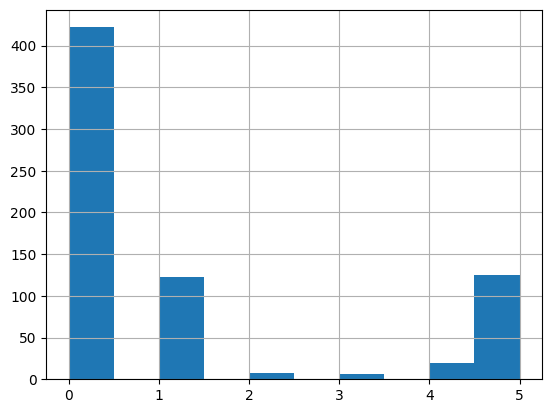

In [19]:
df['rating'].hist()

In [ ]:
import pandas as pd
import json
from typing import List
import re

def clean_text(self, text: str) -> str:
    if not text:
        return ""
    # Заменяем \xa0 и другие проблемные символы на обычные пробелы
    text = text.replace('\xa0', ' ')
    text = text.replace('\u00a0', ' ')
    # Убираем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
    
def classify_review(self, title: str, text: str) -> List[str]:
    title = self.clean_text(title)
    text = self.clean_text(text)
    
    prompt = f"""Ты эксперт по банковским продуктам.
Тебе будет дан текст - отзыв клиента о работе банка и его услугах.
Твоя задача — проанализировать текст и определить, по поводу какого продукта или услуги написан отзыв. 
Если ты не можешь найти упоминания продукта или услуги, то не выводи ничего.
К меткам предъявляются следующие требования:
- В метках должны упоминаться только продукты банка
- Метки не должны включать названия банков
- Метки должны быть короткими (1–3 слова)
- Каждая метка должна быть уникальной (без повторений)

ОТЗЫВ:
Заголовок: "{title}"
Текст: "{text}"

Ответ в формате JSON массива: ["тег1", "тег2"]"""
    
    try:
        response = self._send_request(prompt)
        start = response.find('[')
        end = response.rfind(']') + 1
        if start != -1 and end != 0:
            json_str = response[start:end]
            tags = json.loads(json_str)
            return tags if isinstance(tags, list) else []
        return []
    except Exception as e:
        print(f"Ошибка: {e}")
        return []

def add_classification_tags(df: pd.DataFrame, classifier: ReviewClassifier) -> pd.DataFrame:
    df_copy = df.copy()
    
    def get_tags(row):
        return classifier.classify_review(row['review_title'], row['review_text'])
    
    df_copy['tags'] = df_copy.apply(get_tags, axis=1)
    return df_copy

In [15]:
df.shape

(703, 7)

In [18]:
# Использование
classifier = ReviewClassifier(router=True)
df_with_tags = add_classification_tags(df, classifier)

Ошибка: Extra data: line 2 column 1 (char 3)


In [19]:
df_with_tags.to_csv('df_sravni_labeled.csv', index=False)

In [84]:
df_with_tags = pd.read_csv('df_sravni_labeled.csv')
df_with_tags.head()

,review_tag,date_review,user_name,user_city,review_title,review_text,rating,tags
0,creditCards,2024-03-31,АНАТОЛИЙ,Москва,Банк без моего ведома подключил мне услугу фин...,Оформил кред. Карту «Кредитная карта UnionPay ...,2,"['кредитная карта', 'финансовая защита', 'смс ..."
1,serviceLevel,2024-03-31,Сергей,Москва,Начисление Газпромбанк — Travel,По аналитике расходов за февраль — 144.872 Руб...,0,"['Travel', 'кешбек']"
2,creditCards,2024-03-30,Александр,Саранск,Плохое обслуживание,"Здравствуйте, в прошлом году в марте оформлял ...",0,"['кредитная карта', 'обслуживание карты']"
3,serviceLevel,2024-03-30,Дмитрий,Новокузнецк,Обслуживание,Потребовалась справка для налоговой «платежн...,0,"['справка платежное поручение', 'мобильное при..."
4,savings,2024-03-30,Абрам,Красногорск,Выгодный вклад,"05.02.2024 Посетил отделение банка, на ул. В. ...",0,['вклад']


In [77]:
with open('strings.txt', 'w', encoding='utf-8') as f:
    for string in df_with_tags['tags'].explode().str.lower().unique().tolist():
        f.write(f"{string}\n")

In [85]:
import ast

synonyms = {
    'кешбек': ['кешбэк', 'кэшбэк', 'кэш-бэк', 'кеш-бэк', 'умный кешбек', 'карта с кэшбэком'],
    'кредитная карта': ['кредитка', 'кредитные карты'],
    'дебетовая карта': ['дебитовая карта', 'дебетовые карты', 'зарплатная карта', 'пенсионная карта'],
    'банковская карта': ['карта', 'карты', 'пластиковая карта', 'платежная карта', 'именная карта', 'моментальная карта', 'мгновенная карта', 'умная карта', 'умная карточка', 'премиальная карта', 'рублевая карта'],
    'unionpay': ['карта unionpay', 'карта union pay', 'юнион пэй', 'юнион пей', 'юнипей', 'юнионпэй', 'карта юнионпей', 'карта юнион пэй', 'карта юнион пей', 'карта юнион', 'union pay', 'china union pay', 'upi', 'карта unionpay diamond', 'карта up', 'unipay', 'карта юнионпэй'],
    'смс информирование': ['смс-информирование', 'sms-информирование', 'мобильное информирование', 'информирование', 'оповещения', 'смс-оповещения', 'смс-подтверждение'],
    'техподдержка': ['чат поддержки', 'чат-поддержка', 'онлайн-чат', 'контактный центр', 'колл-центр', 'горячая линия', 'поддержка', 'служба поддержки', 'поддержка клиентов'],
    'страхование': ['страховка', 'исж', 'нсж', 'снж', 'страхование жизни', 'страховка жизни', 'добровольное страхование', 'страхование кредита', 'инвестиционное страхование жизни', 'ренессанс жизнь', 'страховая премия', 'страховой взнос'],
    'акция': ['акции', 'промо акция', 'приведи друга', 'приглашение друга', 'бонус за друга', 'реферальная программа', 'программа лояльности', 'система лояльности', 'бонусная программа'],
    'вклад': ['вклады', 'накопительный счет', 'накопительный счёт', 'накопительный вклад', 'детские вклады', 'накопительные счета', 'депозит', 'сберегательный счет', 'вклад хит сезона', 'льготный вклад', 'вклад почетный', 'инвестиционный вклад', 'калькулятор вкладов', 'досрочное снятие', 'ежедневный процент'],
    'кредит': ['кредиты', 'автокредит', 'потребительский кредит', 'ипотека', 'ипотеки', 'кредит наличными', 'суперкредит', 'онлайн кредит', 'мотокредит', 'кредит на авто', 'кредит на бизнес', 'кредит под залог', 'ипотечный кредит', 'ссудный кредит', 'потребкредит', 'кредитование', 'семейная ипотека', 'кредитный договор', 'кредитный лимит', 'досрочное погашение', 'реструктуризация', 'рефинансирование'],
    'интернет банк': ['интернет-банк', 'онлайн банк', 'онлайн-банк', 'мобильный банк', 'онлайн кабинет', 'личный кабинет', 'интернет-банкинг', 'клиентбанк'],
    'мобильное приложение': ['гпб мобайл', 'мобайл'],
    'обслуживание карты': ['обслуживание карт', 'премиум-обслуживание', 'премиум обслуживание', 'премиальное обслуживание', 'обслуживание в отделении', 'обслуживание в офисе', 'обслуживание клиентов', 'обслуживание счетов', 'обслуживание счета', 'бесплатное обслуживание', 'обслуживание юридических лиц', 'обслуживание юрлиц', 'условия обслуживания', 'договор обслуживания', 'обслуживание за границей'],
    'выписка по счёту': ['выписка', 'выписки', 'банковские выписки', 'выписки по счетам', 'выписка по счету', 'выписка по кредиту'],
    'переводы': ['перевод', 'перевод на карту', 'переводы между картами', 'переводы сбп', 'переводы по сбп', 'переводы в сторонние банки', 'переводы без комиссии', 'переводы с карт', 'перевод с карты', 'международные переводы', 'перевод средств', 'переводы по iban', 'перевод по iban', 'международные платежи', 'розыск платежа', 'возврат средств'],
    'система быстрых платежей': ['сбп'],
    'счета': ['текущий счет', 'карточный счет', 'карточный счёт', 'расчетный счет', 'личный счет', 'кредитный счет', 'счета несовершеннолетних', 'открытие счета', 'закрытие счета'],
    'арест счета': ['арест счетов', 'арест карты', 'снятие ареста'],
    'банкомат': ['банкоматы'],
    'доставка карты': ['доставка карт', 'курьерская доставка'],
    'бонусы': ['бонусные баллы', 'газпромбонус', 'приветственный бонус', 'приветственная надбавка'],
    'тариф': ['тарифы', 'годовой тариф', 'тариф карты'],
    'подписка': ['автоподписки', 'платная подписка', 'подписка привилегия', 'подписка огонь', 'автоподключение услуг'],
    'привилегии плюс': ['привилегия плюс', 'сервис привилегии', 'премиальные привилегии путешественника', 'премиальные сервисы', 'привелегия'],
    'газпромбанк плюс': ['гпб плюс', 'гпб+'],
    'платные услуги': ['платная услуга плюс', 'платные сервисы'],
    'мультисервис': ['еюс мультисервис', 'мультисервис интерактив+', 'мультисервис интерактив +', 'мультисервис интерактив', 'мультиплюс интерактив'],
    'блокировка счета': ['блокировка карты', 'разблокировка счета', 'блокировка средств', 'заморозка средств', 'стоп-лист'],
    'беспроцентный период': ['180 дней без %', '180 дней без процентов', 'безпроцентный период', 'беспроцентная рассрочка', 'льготный период'],
    'бесконтактная оплата': ['бесконтактные платежи'],
}

reverse_synonyms = {}
for main_term, synonym_list in synonyms.items():
    reverse_synonyms[main_term.lower()] = main_term
    for synonym in synonym_list:
        reverse_synonyms[synonym.lower()] = main_term

def parse_tags(tag_string):
    try:
        return ast.literal_eval(tag_string)
    except:
        return []

df_with_tags['tags'] = df_with_tags['tags'].apply(parse_tags)

# Создание колонки с нормализованными тегами
def normalize_tags(tag_list):
    normalized = []
    if isinstance(tag_list, list):
        for tag in tag_list:
            if tag and str(tag).strip():
                normalized_tag = reverse_synonyms.get(str(tag).lower(), str(tag).lower())
                normalized.append(normalized_tag)
    return normalized

df_with_tags['normalized_tags'] = df_with_tags['tags'].apply(normalize_tags)


In [86]:
df_with_tags.head()

,review_tag,date_review,user_name,user_city,review_title,review_text,rating,tags,normalized_tags
0,creditCards,2024-03-31,АНАТОЛИЙ,Москва,Банк без моего ведома подключил мне услугу фин...,Оформил кред. Карту «Кредитная карта UnionPay ...,2,"[кредитная карта, финансовая защита, смс инфор...","[кредитная карта, финансовая защита, смс инфор..."
1,serviceLevel,2024-03-31,Сергей,Москва,Начисление Газпромбанк — Travel,По аналитике расходов за февраль — 144.872 Руб...,0,"[Travel, кешбек]","[travel, кешбек]"
2,creditCards,2024-03-30,Александр,Саранск,Плохое обслуживание,"Здравствуйте, в прошлом году в марте оформлял ...",0,"[кредитная карта, обслуживание карты]","[кредитная карта, обслуживание карты]"
3,serviceLevel,2024-03-30,Дмитрий,Новокузнецк,Обслуживание,Потребовалась справка для налоговой «платежн...,0,"[справка платежное поручение, мобильное прилож...","[справка платежное поручение, мобильное прилож..."
4,savings,2024-03-30,Абрам,Красногорск,Выгодный вклад,"05.02.2024 Посетил отделение банка, на ул. В. ...",0,[вклад],[вклад]


# Жесткая кластеризация

In [87]:
# Определение кластеров
clusters = {
    'банковские карты и платежи': [
        'huawei pay', 'unionpay', 'visa gold', 'автодрайв платиновая', 'банковская карта', 
        'дебетовая карта', 'карта 180 дней', 'карта голд', 'карта для мечты', 
        'карта для поездок', 'карта мир', 'карта путешественника', 'карта рассрочки', 
        'карта с милями', 'кредитная карта', 'бесконтактная оплата', 'мобильные платежи', 
        'онлайн оплата', 'система быстрых платежей'
    ],
    'управление картами и счетами': [
        'активация карты', 'блокировка счета', 'выпуск карты', 'замена карты', 
        'доставка карты', 'перевыпуск карты', 'обслуживание карты', 'лимиты', 
        'арест счета', 'счета'
    ],
    'операции с наличными и переводы': [
        'банкомат', 'внесение наличных', 'снятие наличных', 'обналичивание', 
        'обналичка', 'переводы', 'инкассация', 'платежная операция'
    ],
    'кредиты и рассрочки': [
        'кредит', 'беспроцентный период', 'минимальный платеж', 'автолизинг'
    ],
    'инвестиции и финансовые продукты': [
        'брокерский счет', 'дивиденды', 'доверительное управление', 'иис', 
        'инвестиционный продукт', 'облигации', 'пиф', 'вклад'
    ],
    'бонусы и льготы': [
        'бонусы', 'кешбек', 'кэшбек', 'мили', 'скидки', 'акция', 
        'привилегии плюс', 'проценты на остаток'
    ],
    'банковские услуги и сервисы': [
        'travel', 'путешествия', 'платежи за границей', 'консьерж-сервис', 
        'премиальный менеджер', 'премиальный пакет', 'премиум', 'зарплатный проект', 
        'зарплатный клиент', 'пакет услуг', 'мультисервис', 'тариф'
    ],
    'цифровые сервисы': [
        'интернет банк', 'мобильное приложение', 'онлайн заявка', 'онлайн-обращение', 
        'смс информирование', 'электронная очередь', 'база данных', 'документооборот'
    ],
    'платежи и комиссии': [
        'комиссия', 'возврат комиссии', 'списание комиссии', 'списание средств', 
        'оплата госпошлины', 'оплата жку', 'оплата жкх', 'мобильная связь', 
        'платные услуги', 'подписка', 'пополнение карты'
    ],
    'социальные выплаты и пособия': [
        'детские пособия', 'материнский капитал', 'пенсионные выплаты', 'социальное пособие', 
        'социальные выплаты', 'социальные пособия', 'выплаты', 'сохранение прожиточного минимума'
    ],
    'правовые и административные вопросы': [
        'банкротство физических лиц', 'взыскание', 'исполнительное производство', 
        'исполнительный лист', 'судебное взыскание', 'фссп', 'доверенность', 'наследство', 
        'нотариальный запрос', 'документы для налоговой', 'оформление документов', 
        'справка о доходах', 'справка платежное поручение', 'юридические услуги', 
        'бухгалтерские услуги'
    ],
    'обслуживание и поддержка': [
        'консультации', 'персональный менеджер', 'техподдержка', 'служба безопасности', 
        'обращение клиента', 'отделения банка', 'отзыв персональных данных', 
        'смена паспортных данных', 'выписка по счёту', 'чек', 'перенос номера', 'рко', 
        'аренда ячеек', 'страхование', 'финансовая защита', 'финуслуги', 'конвертация валют', 
        'обмен валют', 'обмен валюты', 'залоговая недвижимость', 'газпромбанк плюс', 
        'сертификат озон', 'серебряная монета', 'спорт'
    ]
}

reverse_clusters = {}
for cluster_name, terms_list in clusters.items():
    for term in terms_list:
        reverse_clusters[term.lower()] = cluster_name

# Создание колонки с кластерами
def assign_clusters(normalized_tags):
    cluster_list = []
    if isinstance(normalized_tags, list):
        for tag in normalized_tags:
            if tag and str(tag).strip():
                cluster_name = reverse_clusters.get(str(tag).lower(), 'без кластера')
                cluster_list.append(cluster_name)
    return cluster_list

df_with_tags['clusters'] = df_with_tags['normalized_tags'].apply(assign_clusters)

# Сохранение уникальных тегов и кластеров
all_normalized_tags = []
all_clusters = []

for tag_list in df_with_tags['normalized_tags']:
    if isinstance(tag_list, list):
        all_normalized_tags.extend(tag_list)

for cluster_list in df_with_tags['clusters']:
    if isinstance(cluster_list, list):
        all_clusters.extend(cluster_list)

unique_tags = set(all_normalized_tags)
unique_clusters = set(all_clusters)

with open('strings_without_synonimus.txt', 'w', encoding='utf-8') as f:
    for tag in sorted(unique_tags):
        f.write(f"{tag}\n")

with open('clusters_assignment.txt', 'w', encoding='utf-8') as f:
    for cluster in sorted(unique_clusters):
        f.write(f"{cluster}\n")

print(f"Записано {len(unique_tags)} уникальных тегов")
print(f"Записано {len(unique_clusters)} уникальных кластеров")

Записано 135 уникальных тегов
Записано 12 уникальных кластеров


In [88]:
df_with_tags.head()

,review_tag,date_review,user_name,user_city,review_title,review_text,rating,tags,normalized_tags,clusters
0,creditCards,2024-03-31,АНАТОЛИЙ,Москва,Банк без моего ведома подключил мне услугу фин...,Оформил кред. Карту «Кредитная карта UnionPay ...,2,"[кредитная карта, финансовая защита, смс инфор...","[кредитная карта, финансовая защита, смс инфор...","[банковские карты и платежи, обслуживание и по..."
1,serviceLevel,2024-03-31,Сергей,Москва,Начисление Газпромбанк — Travel,По аналитике расходов за февраль — 144.872 Руб...,0,"[Travel, кешбек]","[travel, кешбек]","[банковские услуги и сервисы, бонусы и льготы]"
2,creditCards,2024-03-30,Александр,Саранск,Плохое обслуживание,"Здравствуйте, в прошлом году в марте оформлял ...",0,"[кредитная карта, обслуживание карты]","[кредитная карта, обслуживание карты]","[банковские карты и платежи, управление картам..."
3,serviceLevel,2024-03-30,Дмитрий,Новокузнецк,Обслуживание,Потребовалась справка для налоговой «платежн...,0,"[справка платежное поручение, мобильное прилож...","[справка платежное поручение, мобильное прилож...","[правовые и административные вопросы, цифровые..."
4,savings,2024-03-30,Абрам,Красногорск,Выгодный вклад,"05.02.2024 Посетил отделение банка, на ул. В. ...",0,[вклад],[вклад],[инвестиции и финансовые продукты]


In [89]:
df_with_tags.to_csv('cluser.csv', index=False)